In [14]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
import tensorflow as tf
import keras_metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import math
import datetime as dt
from keras.layers import Dense, Activation, Dropout, LSTM, BatchNormalization
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers

In [15]:
test_dataset = pd.read_csv('PatientData591test.csv', header = 0, index_col = 0)
test_dataset.columns

Index([' glucose_level', ' finger_stick_value', ' basal_value',
       'temp_basal_value', ' bolus_dose', ' bolus_carb_input', ' meal_carbs',
       ' sleep_quality', ' duration', ' intensity', ' basis_heartrate_value',
       ' basis_gsr_value', ' basis_skin_temp_value', 'basis_air_temp',
       ' basis_steps', ' basis_sleep_quality'],
      dtype='object')

In [16]:
# load dataset
dataset = pd.read_csv('PatientDataAll.csv', header=0, index_col=0)
dataset.columns

Index([' glucose_level', ' finger_stick_value', ' basal_value',
       'temp_basal_value', ' bolus_dose', ' bolus_carb_input', 'meal_carbs',
       'sleep_quality', 'duration', 'intensity', 'basis_heartrate_value',
       'basis_gsr_value', 'basis_skin_temp_value', 'basis_air_temp',
       'basis_steps', 'basis_sleep_quality'],
      dtype='object')

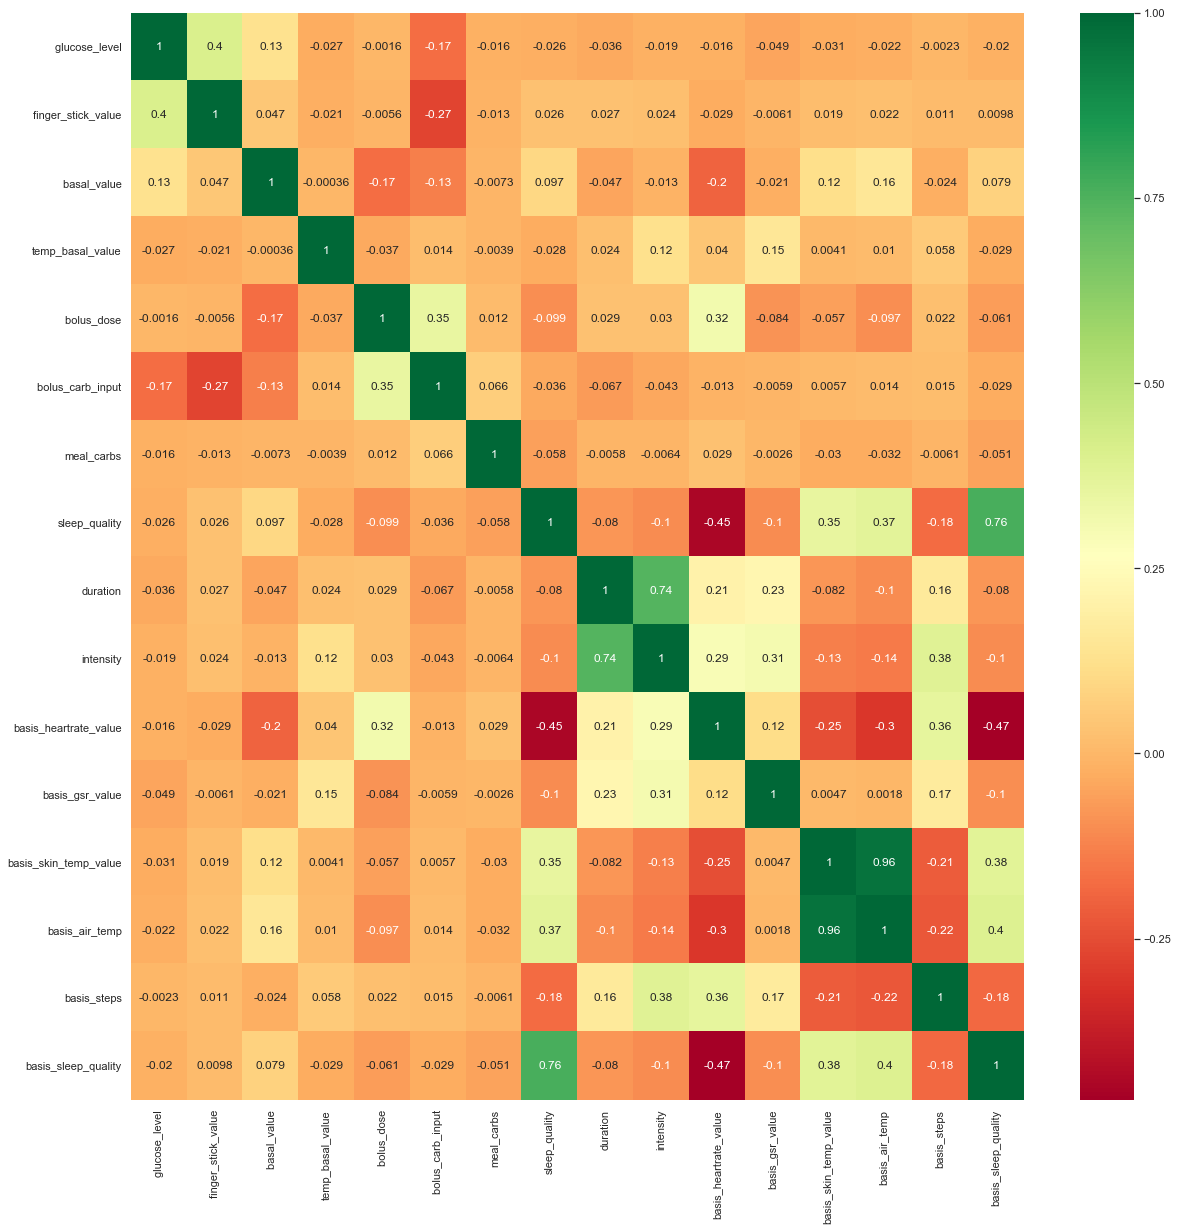

In [17]:
#correlation among independant variables of full dataset of required variables
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
X = dataset #independent columns

#get correlations of each features in dataset
corrmat = pd.DataFrame(X).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(pd.DataFrame(X[top_corr_features]).corr(),annot=True,cmap="RdYlGn")
g=sns.heatmap(pd.DataFrame(X).corr(),annot=True,cmap="RdYlGn")

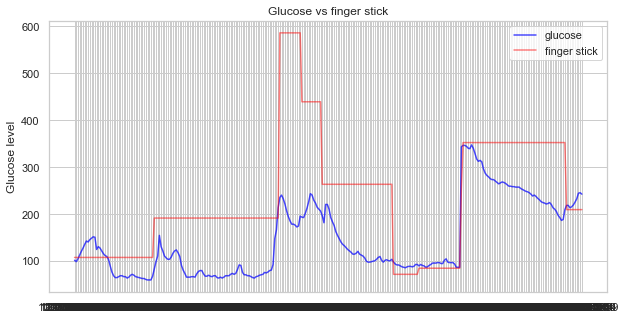

In [18]:
plt.figure(figsize=(10,5))
plt.plot(dataset[' glucose_level'][0:300], color ='blue', alpha = 0.7,label = "glucose")
plt.plot(dataset[' finger_stick_value'][0:300],color='red',alpha = 0.5, label = "finger stick")
plt.legend()
plt.ylabel("Glucose level")

plt.title("Glucose vs finger stick")
plt.show()

In [19]:
#df1=dataset.drop([' bolus_dose',' bolus_carb_input', 'meal_carbs',
       #'sleep_quality', 'duration', 'intensity', 'basis_heartrate_value',
       #'basis_gsr_value', 'basis_skin_temp_value', 'basis_air_temp',
       #'basis_steps', 'basis_sleep_quality','temp_basal_value'], axis =1)
#df1.head()

In [27]:
#Load test dataset
test_dataset = pd.read_csv('PatientData591test.csv', header = 0, index_col = 0)
#df_test=test_dataset.drop([' bolus_dose', ' bolus_carb_input', ' meal_carbs',
       #' sleep_quality', ' duration', ' intensity', ' basis_heartrate_value',
       #' basis_gsr_value', ' basis_skin_temp_value', 'basis_air_temp',
       #' basis_steps', ' basis_sleep_quality','temp_basal_value'], axis =1)

test_values = test_dataset.values

# ensure all data is float
values = dataset.values
values = values.astype('float32')
test_values = test_values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_df = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(values)
test_scaled = scaler.fit_transform(test_values)

#df = scaler_df.fit_transform(df1)

# train the training set and test the testing set
train=scaled
test=test_scaled

split= round(len(train)*0.8)

# split into input and outputs
train_X0, train_y0 = train[:split, 1:], train[:split, 0]
val_X0, val_y0 = train[split:,1:], train[split:,0]
test_X0, test_y0 = test[:, 1:], test[:, 0]

train_y=np.asarray(train_y0).reshape(( -1 , 1 ))
val_y=np.asarray(val_y0).reshape(( -1 , 1 ))
test_y=np.asarray(test_y0).reshape(( -1 , 1 ))

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X0.reshape((train_X0.shape[0], 1, train_X0.shape[1]))
val_X = val_X0.reshape((val_X0.shape[0], 1, val_X0.shape[1]))
test_X = test_X0.reshape((test_X0.shape[0], 1, test_X0.shape[1]))
print("Train X shape: ", train_X.shape)
print("Train y shape: ", train_y.shape)
print("Validation X shape: ", val_X.shape)
print("Validation y shape: ", val_y.shape)
print("Test X shape: ", test_X.shape)
print("Test y shape: ", test_y.shape)

Train X shape:  (53653, 1, 15)
Train y shape:  (53653, 1)
Validation X shape:  (13413, 1, 15)
Validation y shape:  (13413, 1)
Test X shape:  (2760, 1, 15)
Test y shape:  (2760, 1)


In [28]:
# design network
model = Sequential()
model.add(LSTM(units=100, input_shape=(train_X.shape[1], train_X.shape[2]) 
               ,  return_sequences= True))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss = 'mse', 
              optimizer = adam)
model.summary()


callbacks = [
        EarlyStopping(monitor='val_loss', patience=8)
        #ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 100)            46400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 126,901
Trainable params: 126,901
Non-trainable params: 0
_________________________________________________________________


Train on 53653 samples, validate on 13413 samples
Epoch 1/30
53653/53653 [==============================] - 8s 142us/step - loss: 0.0319 - val_loss: 0.0210
Epoch 2/30
53653/53653 [==============================] - 6s 116us/step - loss: 0.0238 - val_loss: 0.0207
Epoch 3/30
53653/53653 [==============================] - 6s 117us/step - loss: 0.0236 - val_loss: 0.0205
Epoch 4/30
53653/53653 [==============================] - 6s 120us/step - loss: 0.0235 - val_loss: 0.0207
Epoch 5/30
53653/53653 [==============================] - 6s 119us/step - loss: 0.0234 - val_loss: 0.0206
Epoch 6/30
53653/53653 [==============================] - 6s 119us/step - loss: 0.0233 - val_loss: 0.0205
Epoch 7/30
53653/53653 [==============================] - 6s 119us/step - loss: 0.0232 - val_loss: 0.0207
Epoch 8/30
53653/53653 [==============================] - 7s 125us/step - loss: 0.0232 - val_loss: 0.0204
Epoch 9/30
53653/53653 [==============================] - 7s 129us/step - loss: 0.0231 - val_loss: 0.0

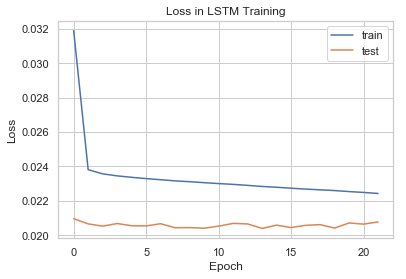

In [29]:
# fit network
history = model.fit(train_X, train_y, epochs= 30, batch_size=32, validation_data=(val_X, val_y) ,
                   callbacks=callbacks)

                #  , verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [30]:
val_X.shape

(13413, 1, 15)

In [31]:
# make a prediction
yhat = model.predict(val_X)
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((yhat, val_X), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual

val_y = val_y.reshape((len(val_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((val_y, val_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
rmse

35.74696945470081

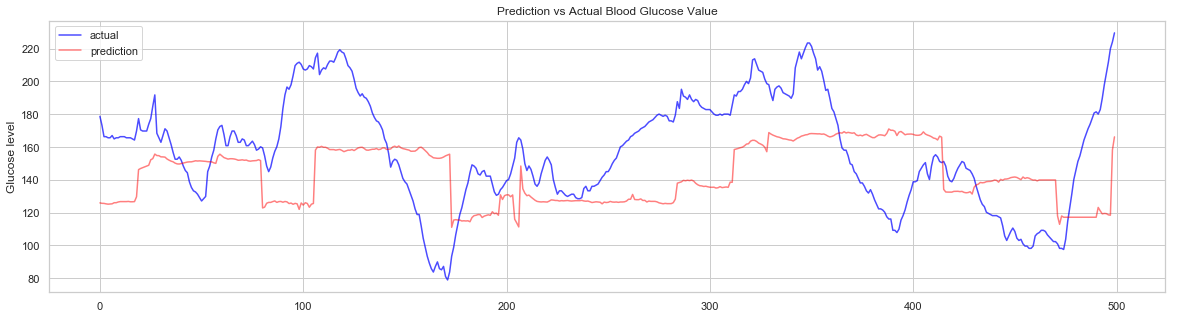

In [32]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[0:500], color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1[0:500],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()

## Only Glucose

In [57]:
def series_to_supervised(sequence, steps):
    
    X,y = list(), list()
    for i in range(len(sequence)-steps-1):
        target = i + steps
        if target > len(sequence)-2:
            break
        seq_x = sequence[i:target]
            
        seq_y = sequence[target+1]
        
        X.append(seq_x)
        y.append(seq_y)
        
        
    return X,y
            

(53648, 1, 5) (53648,) (13412, 1, 5) (13412,)
Train on 53648 samples, validate on 13412 samples
Epoch 1/10
53648/53648 [==============================] - 11s 211us/step - loss: 0.0033 - val_loss: 0.0013
Epoch 2/10
53648/53648 [==============================] - 9s 160us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/10
53648/53648 [==============================] - 9s 163us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/10
53648/53648 [==============================] - 9s 163us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/10
53648/53648 [==============================] - 9s 165us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/10
53648/53648 [==============================] - 9s 169us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/10
53648/53648 [==============================] - 9s 164us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/10
53648/53648 [==============================] - 9s 168us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/10
53648/53648 [==============================]

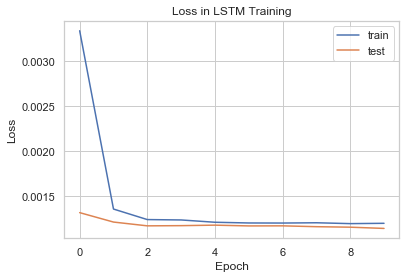

In [58]:
glucose=values[:,0]
X,y=series_to_supervised(glucose, 5)
split_point = round(len(X)*0.8)

df = pd.DataFrame(X)
df['target']= y
df
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))
data = scaler1.fit_transform(df)
X=data[:,:-1]
y=data[:,-1]

train_X, train_y = X[:split_point], y[:split_point]
test_X, test_y = X[split_point:], y[split_point:]

train_X=np.asarray(train_X)
test_X=np.asarray(test_X)

train_y=np.asarray(train_y)
test_y=np.asarray(test_y)



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(100, activation = 'linear', input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(BatchNormalization()) 
model.add(Dropout(0.5))
#model.add(LSTM(256))
#model.add(Dropout(0.5))
model.add(Dense(1))
#model.add(Activation("linear"))
model.compile(loss = "mse", 
              optimizer = "adam")
#model.summary()


#model.add(Dense(Y_modified.shape[1], activation='softmax'))
#model.add(Dense(1))

#model.compile(optimizer='adam',loss='mean_squared_error')

# fit network
history = model.fit(train_X, train_y, epochs= 10, batch_size=16, validation_data=(test_X, test_y))#  , verbose=2, shuffle=False)
#history = model.fit(train_X, train_y, epochs= 5, batch_size=256)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Loss in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [59]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat1 = scaler1.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual

test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler1.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat1))
rmse

12.16831690630548

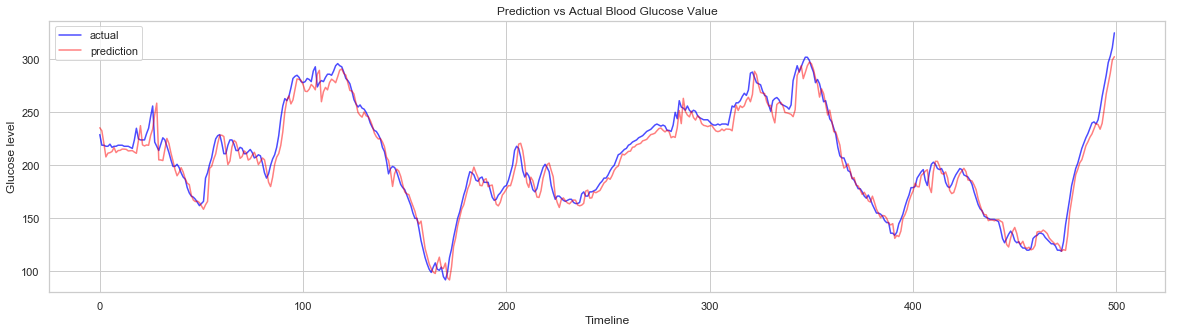

In [62]:
plt.figure(figsize=(20,5))
plt.plot(inv_y[:500], color ='blue', alpha = 0.7,label = "actual")
plt.plot(inv_yhat1[:500],color='red',alpha = 0.5, label = "prediction")
plt.legend()
plt.ylabel("Glucose level")
plt.xlabel("Timeline")
plt.title("Prediction vs Actual Blood Glucose Value")
plt.show()